In [39]:
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! wget https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_alt2.xml
! bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2021-07-09 13:29:23--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  41.1MB/s    in 1.5s    

2021-07-09 13:29:25 (41.1 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

--2021-07-09 13:29:25--  https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_alt2.xml
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘haarcascade_frontalface_alt2.xml.1’

haarcascade_frontal     [ <=>                ]   5.07M  --.-KB/s    in 0.1s    

2021-07-09 13:29:26 (44.0 MB/s) - ‘h

In [5]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def forehead_area(points,y=0):
  top_left = [points[18, 0], y]
  bottom_right = [points[25, 0], points[[19, 24], 1].min()]
  #rect = patches.Rectangle(top_left, bottom_right[0]-top_left[0], bottom_right[1]-top_left[1], linewidth=1, edgecolor='r', facecolor='none')
  #plt.axes().add_patch(rect)
  return (top_left, bottom_right)

def left_eye_area(points):
  top_left=points[17]
  bottom_right=[points[36,0],points[[0,1],1].mean()]
  #rect = patches.Rectangle(top_left, bottom_right[0]-top_left[0], bottom_right[1]-top_left[1], linewidth=1, edgecolor='r', facecolor='none')
  #plt.axes().add_patch(rect)
  return (top_left,bottom_right)

def right_eye_area(points):
  top_right=points[26]
  bottom_left=[points[45,0],points[[15,16],1].mean()]
  #rect = patches.Rectangle(top_right, bottom_left[0]-top_right[0], bottom_left[1]-top_right[1], linewidth=1, edgecolor='r', facecolor='none')
  #plt.axes().add_patch(rect)
  return ([bottom_left[0],top_right[1]],[top_right[0],bottom_left[1]])

def left_cheek_area(points):
  top_left=[points[[36,41],0].mean(),points[41,1]]
  bottom_right=[points[[40,39],0].mean(),points[[33,51],1].mean()]
  #rect = patches.Rectangle(top_left, bottom_right[0]-top_left[0], bottom_right[1]-top_left[1], linewidth=1, edgecolor='r', facecolor='none')
  #plt.axes().add_patch(rect) 
  return (top_left,bottom_right)

def right_cheek_area(points):
  top_right=[points[[46,45],0].mean(),points[46,1]]
  bottom_left=[points[[42,47],0].mean(),points[[33,51],1].mean()]
  #rect = patches.Rectangle(top_right, bottom_left[0]-top_right[0], bottom_left[1]-top_right[1], linewidth=1, edgecolor='r', facecolor='none')
  #plt.axes().add_patch(rect)
  return ([bottom_left[0],top_right[1]],[top_right[0],bottom_left[1]])

def wrinkle_density(edges, slice_1, slice2):
  return (edges[int(slice_1[1]): int(slice2[1]),
                int(slice_1[0]): int(slice2[0])].mean())/255 

def create_wrinkle_df(images, landmarks, method):
    wrinkles = []
    for img, points in zip(images, landmarks):
        # extract wrinkles 
        wrinkle_1_top,   wrinkle_1_bottom   = forehead_area(   points)
        wrinkle_2_1_top, wrinkle_2_1_bottom = left_eye_area(   points)
        wrinkle_2_2_top, wrinkle_2_2_bottom = right_eye_area(  points)
        wrinkle_3_1_top, wrinkle_3_1_bottom = left_cheek_area( points)
        wrinkle_3_2_top, wrinkle_3_2_bottom = right_cheek_area(points)

        # extract the wrinkles using the method given in input
        # edges = cv2.Canny(img, 60, 70)
        edges = method(img)
        
        wrinkles.append({
            'wrinkle_1': wrinkle_density(edges, wrinkle_1_top, wrinkle_1_bottom),
            'wrinkle_2': np.mean([wrinkle_density(edges, wrinkle_2_1_top, wrinkle_2_1_bottom),
                                  wrinkle_density(edges, wrinkle_2_2_top, wrinkle_2_2_bottom)]),
            'wrinkle_3': np.mean([wrinkle_density(edges, wrinkle_3_1_top, wrinkle_3_1_bottom),
                                  wrinkle_density(edges, wrinkle_3_2_top, wrinkle_3_2_bottom)])
        })
    return pd.DataFrame(wrinkles).fillna(0)

In [7]:
def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)
 
#add rectangles of interest on the image
def plot_rect(top_left, bottom_right):
    rect = patches.Rectangle(top_left, 
                             bottom_right[0]-top_left[0], 
                             bottom_right[1]-top_left[1], 
                             linewidth=1, edgecolor='r', 
                             facecolor='none')
    plt.axes().add_patch(rect) 

In [8]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/shape_predictor_68_face_landmarks.dat')

In [9]:
dataset_liu='/content/drive/MyDrive/SL/src/data/datasetLiula/'
photo_files = glob.glob(dataset_liu + '*.jpeg')

In [22]:
data_path = "/content/drive/MyDrive/SL/src/data/" 
plot_path = data_path + 'plots/'

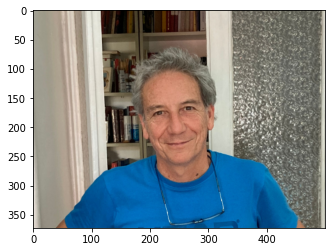

In [10]:
# extract the first face

image = cv2.imread(photo_files[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = imutils.resize(image, width=500)
plt.imshow(image)
#plt.axis('off')
#image = imutils.resize(image, width=500)
#plt.savefig("nonno_liu_intero.png")

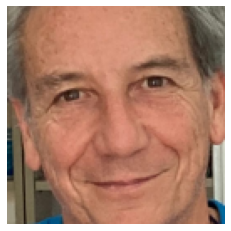

In [11]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/SL/src/models/frontalFace10/haarcascade_frontalface_alt2.xml')
faces = face_cascade.detectMultiScale(image, 1.1, 4)

for (x, y, w, h) in faces:
    #cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 0)
    faces = image[y:y + h, x:x + w]
    plt.imshow(faces, cmap='gray')
    plt.axis('off')
faces = imutils.resize(faces, width=200) 


In [13]:
# extract the face landmarks
gray = cv2.cvtColor(faces, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 1)
shape = predictor(gray, rects[0])
shape = face_utils.shape_to_np(shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


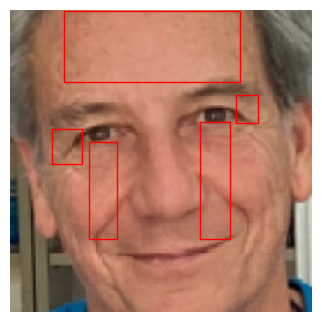

In [40]:
#face with areas of interests

plt.figure(figsize=(4,4), dpi=100)

plot_rect(*forehead_area   (shape))
plot_rect(*left_eye_area   (shape))
plot_rect(*right_eye_area  (shape))
plot_rect(*left_cheek_area (shape))
plot_rect(*right_cheek_area(shape))
plt.axis('off')
plt.imshow(faces)
plt.show()

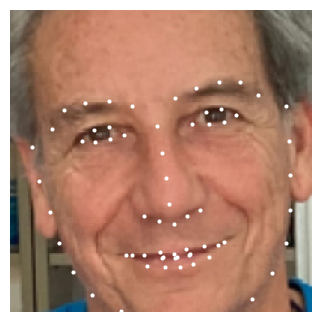

In [19]:
#plot landmarks on face
plt.figure(figsize=(4,4), dpi=100)

plt.scatter(shape[:,0],shape[:,1],c='white',linewidths=0.1,s=8)
plt.axis('off')
plt.imshow(faces)
plt.show()

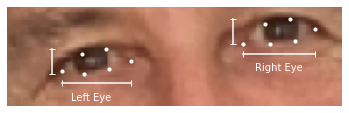

In [ ]:
# eyes zoom 

plt.ylim((100,60))
plt.xlim((25,160))
plt.imshow(faces)

#Left eye
p = points[36:42]
displ = 5
plt.scatter(p[:, 0], p[:, 1],c='white',linewidths=0.1,s=16)
plt.plot([p[:, 0].min() - displ+1]*2, [p[:, 1].min(), p[:, 1].max()],'-_',c='white')
plt.plot([p[:, 0].min(), p[:, 0].max()], [p[:, 1].max() + displ-1]*2,'-|',c='white')

#Right eye
p2 = points[42:48]
plt.scatter(p2[:, 0], p2[:, 1],c='white',linewidths=0.1,s=16)
plt.plot([p2[:, 0].min() - displ+1]*2, [p2[:, 1].min(), p2[:, 1].max()],'-_',c='white')
plt.plot([p2[:, 0].min(), p2[:, 0].max()], [p2[:, 1].max() + displ-1]*2,'-|',c='white')
plt.text(p2[:, 0].mean()-10, p2[:, 1].mean()+15,'Right Eye',c='white')
plt.text(p[:, 0].mean()-10, p[:, 1].mean()+15,'Left Eye',c='white')
plt.axis('off')
plt.savefig(plot_path +"nonno_liu_dist_eyes")

plt.show()

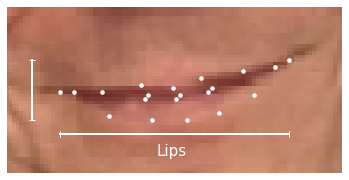

In [25]:
# lips zoom 

plt.imshow(faces)

p = points[48:68]
displ = 15
plt.ylim(p[:, 1].max() + displ, p[:, 1].min() - displ)
plt.xlim(p[:, 0].min() - displ, p[:, 0].max() + displ)
plt.scatter(p[:, 0], p[:, 1],c='white',linewidths=0.1,s=20)
plt.plot([p[:, 0].min() - 8]*2, [p[:, 1].min(), p[:, 1].max()],'-_',c='white',linewidth=2)
plt.plot([p[:, 0].min(), p[:, 0].max()], [p[:, 1].max() +4]*2,'-|',c='white',linewidth=2)
plt.text(p[:, 0].mean()-6, p[:, 1].mean()+18,'Lips',c='white',size=15)
plt.axis('off')
plt.savefig(plot_path +"nonno_liu_dist_mouth")

plt.show()


In [31]:
#define the principal landmarks for the compute the ratios and all the other features

points=shape
points_principal = np.array([
    [100, 0],#top head
    points[0],#left_jaw
    points[4],#left_sof
    points[33],#nose
    [points[36:42,0].mean(), points[36:42,1].mean()],#left_eye
    [points[42:48,0].mean(), points[42:48,1].mean()],#right_eye
    [points[[61,62,63,65,66,67],0].mean(), points[[61,62,63,65,66,67],1].mean()],#lip
    points[12],#right sof
    points[16],#right_jaw
    #points[8],#chin
    [119,199]#chin

])


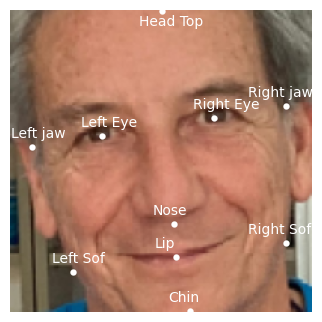

In [32]:
plt.figure(figsize=(4,4), dpi=100)

plt.scatter(points_principal[:,0],points_principal[:,1],c='white',linewidths=0.1,s=20)

texts=['Head Top','Left jaw', 'Left Sof', 'Nose', 'Left Eye', 'Right Eye', 'Lip','Right Sof', 'Right jaw','Chin']
[plt.text(points_principal[i][0] -14, points_principal[i][1] -6, str(texts[i]),c='white') for i in range(1,7)]
plt.text(points_principal[0][0] -15, points_principal[0][1] +10, str(texts[0]),c='white')
[plt.text(points_principal[i][0] -25, points_principal[i][1] -6, str(texts[i]),c='white') for i in range(7,points_principal.shape[0]-1)]
plt.text(points_principal[-1][0] -15, points_principal[-1][1] -6, str(texts[-1]),c='white')

plt.axis('off')
plt.imshow(faces)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


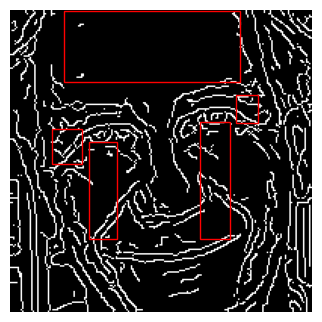

In [33]:
# image with edges 

low_thresh = 35
high_thresh = 50
edge_detection_method = lambda _img: cv2.Canny(cv2.blur(_img,(4,4)), low_thresh, high_thresh)

plt.figure(figsize=(4,4), dpi=100)
plt.imshow(edge_detection_method(faces), cmap='gray')
plot_rect(*forehead_area   (points))
plot_rect(*left_eye_area   (points))
plot_rect(*right_eye_area  (points))
plot_rect(*left_cheek_area (points))
plot_rect(*right_cheek_area(points))
plt.axis('off')
plt.show()

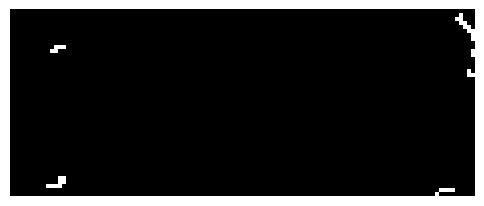

In [34]:
# first area of interest 
# top head wrinkles

wrinkle_1_top,wrinkle_1_bottom=forehead_area(points)
wrinkle_2_1_top,wrinkle_2_1_bottom=left_eye_area(points)
wrinkle_2_2_top,wrinkle_2_2_bottom=right_eye_area(points)
wrinkle_3_1_top,wrinkle_3_1_bottom=left_cheek_area(points)
wrinkle_3_2_top,wrinkle_3_2_bottom=right_cheek_area(points)
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(edge_detection_method(faces)[wrinkle_1_top[1]:wrinkle_1_bottom[1],
                                      wrinkle_1_top[0]:wrinkle_1_bottom[0]], 
           cmap='gray')
plt.axis('off')
plt.show()

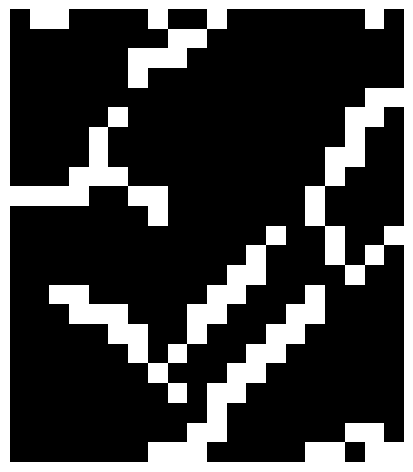

In [35]:
# second area of interest 
# left eye

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(edge_detection_method(faces)[wrinkle_2_1_top[1]:int(wrinkle_2_1_bottom[1]),
                                      wrinkle_2_1_top[0]:int(wrinkle_2_1_bottom[0])], 
           cmap='gray')
plt.axis('off')
plt.show()

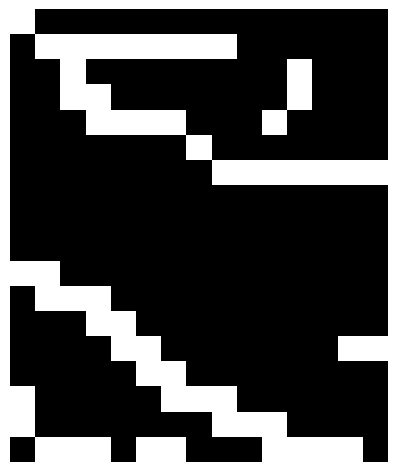

In [36]:
#second area of interest 
#right eye

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(edge_detection_method(faces)[wrinkle_2_2_top[1]:int(wrinkle_2_2_bottom[1]),
                                      wrinkle_2_2_top[0]:int(wrinkle_2_2_bottom[0])], 
           cmap='gray')
plt.axis('off')
plt.show()


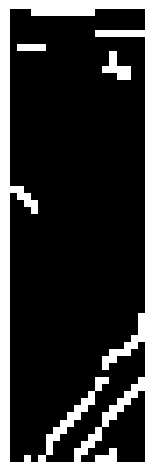

In [37]:
#third area of interest 
#left cheeck

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(edge_detection_method(faces)[int(wrinkle_3_1_top[1]):int(wrinkle_3_1_bottom[1]),
                                      int(wrinkle_3_1_top[0]):int(wrinkle_3_1_bottom[0])], 
           cmap='gray')
plt.axis('off')
plt.show()

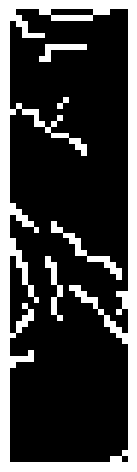

In [38]:
#third area of interest
#right cheek

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(edge_detection_method(faces)[int(wrinkle_3_2_top[1]):int(wrinkle_3_2_bottom[1]),
                                      int(wrinkle_3_2_top[0]):int(wrinkle_3_2_bottom[0])], 
           cmap='gray')
plt.axis('off')
plt.show()

In [ ]:

img_cut_fold='/content/drive/MyDrive/SL/src/data/cropped_dataset/'
with open ('/content/drive/MyDrive/SL/src/data/landmarkliu3.txt','w') as f:
  for p in photo_files:
    image = cv2.imread(p)
    image = imutils.resize(image, width=500)
    faces = face_cascade.detectMultiScale(image, 1.1, 2)
    if len(faces)!=0:
      x, y, w, h = faces[0]
      faces = image[y:y + h, x:x + w]
      gray = cv2.cvtColor(faces, cv2.COLOR_BGR2GRAY)
      rects = detector(gray, 1)
      if len(rects)!=0 :
        shape = predictor(gray, rects[0])
        shape = face_utils.shape_to_np(shape)
        cv2.imwrite(img_cut_fold+p.split('/')[-1], faces)
        f.write(p.split('/')[-1]+ str(shape.flatten()).strip('[]').replace('\n','')+'\n')
      else:
        print('problema 1 immagine non riconosciuta')
        #cv2_imshow(faces)
    else:
      print('problema 2 faccia non tagliata')
      #cv2_imshow(image)


problema 1 immagine non riconosciuta
problema 2 faccia non tagliata
problema 2 faccia non tagliata
problema 1 immagine non riconosciuta
problema 1 immagine non riconosciuta
problema 1 immagine non riconosciuta
problema 1 immagine non riconosciuta
problema 1 immagine non riconosciuta
problema 1 immagine non riconosciuta
problema 2 faccia non tagliata
problema 1 immagine non riconosciuta
problema 1 immagine non riconosciuta
problema 2 faccia non tagliata
problema 2 faccia non tagliata
problema 2 faccia non tagliata
